In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/PlantVillage'

In [ ]:
import os
os.listdir(data_dir)

['Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Bacterial_spot',
 'Tomato__Target_Spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Pepper__bell___healthy']

In [ ]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Tomato__Tomato_YellowLeaf__Curl_Virus : 3209
Tomato_Leaf_Mold : 952
Tomato_Spider_mites_Two_spotted_spider_mite : 1676
Tomato__Tomato_mosaic_virus : 373
Tomato_Bacterial_spot : 2127
Tomato__Target_Spot : 1404
Tomato_Early_blight : 1000
Tomato_Late_blight : 1909
Tomato_Septoria_leaf_spot : 1771
Tomato_healthy : 1591
Potato___Early_blight : 1000
Potato___Late_blight : 1000
Pepper__bell___Bacterial_spot : 997
Potato___healthy : 152
Pepper__bell___healthy : 1478


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

20638

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=256x256>, 0)

In [ ]:
dataset.classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

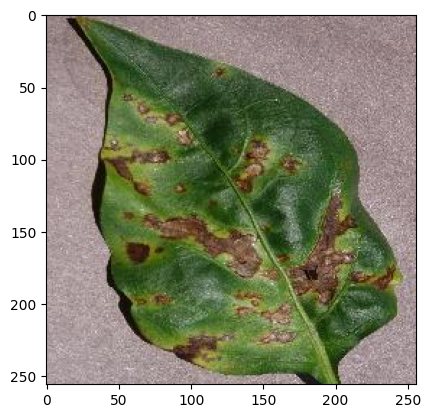

In [ ]:
img, label = dataset[120]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

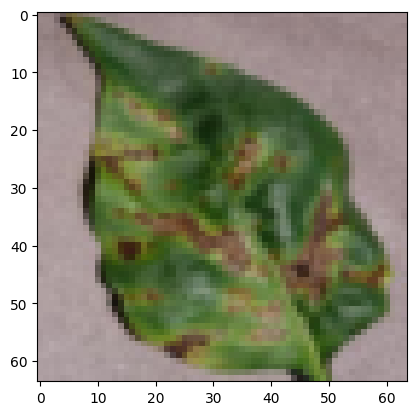

In [ ]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(18575, 2063)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(18575, 2063)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

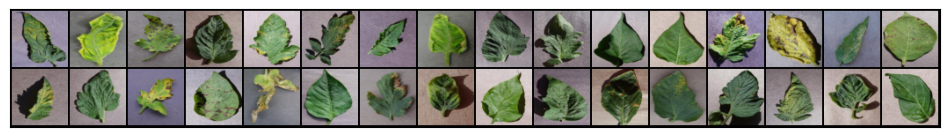

In [ ]:
show_batch(train_dl)

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, f1_score

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss, accuracy, precision and f1 score for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        preds = torch.argmax(out, dim=1)      # Get predicted labels
        acc = accuracy(out, labels)           # Calculate accuracy
        # Calculate precision and F1 score
        precision = precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=1)
        return {'val_loss': loss.detach(), 'val_acc': acc, 'val_precision': precision, 'val_f1': f1}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    val_losses = [x['val_loss'] for x in outputs]
    val_accs = [x['val_acc'] for x in outputs]
    val_precisions = [x['val_precision'] for x in outputs]
    val_f1s = [x['val_f1'] for x in outputs]
    epoch_loss = torch.stack(val_losses).mean()   # Combine losses
    epoch_acc = torch.stack(val_accs).mean()      # Combine accuracies
    epoch_precision = torch.tensor(sum(val_precisions)/len(val_precisions))
    epoch_f1 = torch.tensor(sum(val_f1s)/len(val_f1s))
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_precision': epoch_precision.item(), 'val_f1': epoch_f1.item()}


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # Print precision and F1 score
        print("Precision: {:.4f}, F1 score: {:.4f}".format(result['val_precision'], result['val_f1']))
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


import torch.nn as nn
import torchvision.models as models

class VGG16(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the last layer (classifier) from VGG16
        self.features = nn.Sequential(*list(vgg16.features.children())[:-1])

        # Add our own classifier
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(512 * 4 * 4, 256),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(0.2),
                                         nn.Linear(256, num_classes))

    def forward(self, xb):
        out = self.features(xb)
        out = self.classifier(out)
        return out

class CNN(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 32) # 128 x 32 x 64 x 64
        self.conv2 = conv_block(32, 64, pool=True) # 128 x 64 x 32 x 32
        self.conv3 = conv_block(64, 128, pool=True) # 128 x 128 x 16 x 16
        self.conv4 = conv_block(128, 256, pool=True) # 128 x 256 x 8 x 8
        self.conv5 = conv_block(256, 512, pool=True) # 128 x 512 x 4 x 4
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.classifier(out)
        return out


# Define the stacking model
class EnsembleStackingModel(ImageClassificationBase):
    def __init__(self, vgg16, cnn, num_classes):
        super(EnsembleStackingModel, self).__init__()
        self.vgg16 = vgg16
        self.cnn = cnn
        self.num_classes = num_classes

        self.fc1 = nn.Linear(2*num_classes, num_classes)

    def forward(self, x):
        vgg_out = self.vgg16(x)
        cnn_out = self.cnn(x)
        out = torch.cat((vgg_out, cnn_out), dim=1)
        out = self.fc1(out)
        return out

In [ ]:
# create instances of VGG16 and ResNet5
vgg16 = VGG16(in_channels=3, num_classes=len(dataset.classes))
cnn = CNN(in_channels=3, num_classes=len(dataset.classes))

# create an instance of EnsembleStackingModel
model = EnsembleStackingModel(vgg16, cnn, num_classes=len(dataset.classes))

# move the model to the device
model = to_device(model, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 52.7MB/s]


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
model.vgg16.features[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    images = to_device(images, device)
    labels = to_device(labels, device)
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape torch.Size([32, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([32, 15])


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.739332437515259,
  'val_acc': 0.044294871389865875,
  'val_precision': 0.922125321388196,
  'val_f1': 0.012189401511769287}]

In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1432, val_loss: 0.1172, val_acc: 0.9596
Precision: 0.9779, F1 score: 0.9597


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1], train_loss: 0.0717, val_loss: 0.0732, val_acc: 0.9721
Precision: 0.9823, F1 score: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2], train_loss: 0.0523, val_loss: 0.1779, val_acc: 0.9500
Precision: 0.9716, F1 score: 0.9485


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3], train_loss: 0.0403, val_loss: 0.1547, val_acc: 0.9465
Precision: 0.9695, F1 score: 0.9461


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4], train_loss: 0.0402, val_loss: 0.1025, val_acc: 0.9697
Precision: 0.9815, F1 score: 0.9691


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.0437, val_loss: 0.0683, val_acc: 0.9807
Precision: 0.9874, F1 score: 0.9790


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1], train_loss: 0.0269, val_loss: 0.1090, val_acc: 0.9760
Precision: 0.9846, F1 score: 0.9756


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2], train_loss: 0.0309, val_loss: 0.0438, val_acc: 0.9889
Precision: 0.9944, F1 score: 0.9890


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3], train_loss: 0.0247, val_loss: 0.0992, val_acc: 0.9740
Precision: 0.9834, F1 score: 0.9729


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4], train_loss: 0.0297, val_loss: 0.0646, val_acc: 0.9803
Precision: 0.9872, F1 score: 0.9799


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.0263, val_loss: 0.1107, val_acc: 0.9764
Precision: 0.9851, F1 score: 0.9765


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1], train_loss: 0.0295, val_loss: 0.1283, val_acc: 0.9711
Precision: 0.9834, F1 score: 0.9711


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2], train_loss: 0.0180, val_loss: 0.0460, val_acc: 0.9837
Precision: 0.9894, F1 score: 0.9829


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3], train_loss: 0.0272, val_loss: 0.0484, val_acc: 0.9899
Precision: 0.9934, F1 score: 0.9897


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4], train_loss: 0.0169, val_loss: 0.0818, val_acc: 0.9760
Precision: 0.9853, F1 score: 0.9748


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.0249, val_loss: 0.0308, val_acc: 0.9918
Precision: 0.9954, F1 score: 0.9921


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1], train_loss: 0.0226, val_loss: 0.1325, val_acc: 0.9586
Precision: 0.9769, F1 score: 0.9579


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2], train_loss: 0.0092, val_loss: 0.0726, val_acc: 0.9822
Precision: 0.9884, F1 score: 0.9815


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3], train_loss: 0.0085, val_loss: 0.0714, val_acc: 0.9832
Precision: 0.9893, F1 score: 0.9823


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4], train_loss: 0.0138, val_loss: 0.0632, val_acc: 0.9880
Precision: 0.9934, F1 score: 0.9884


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0223, val_loss: 0.0598, val_acc: 0.9837
Precision: 0.9899, F1 score: 0.9834


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1], train_loss: 0.0128, val_loss: 0.0561, val_acc: 0.9899
Precision: 0.9939, F1 score: 0.9898


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2], train_loss: 0.0074, val_loss: 0.1061, val_acc: 0.9764
Precision: 0.9854, F1 score: 0.9753


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3], train_loss: 0.0247, val_loss: 0.0540, val_acc: 0.9846
Precision: 0.9906, F1 score: 0.9847


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4], train_loss: 0.0137, val_loss: 0.0894, val_acc: 0.9740
Precision: 0.9843, F1 score: 0.9741


In [ ]:
history += fit(4, 0.0001, model, train_dl, valid_dl)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.0044, val_loss: 0.0568, val_acc: 0.9837
Precision: 0.9909, F1 score: 0.9839


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1], train_loss: 0.0045, val_loss: 0.0552, val_acc: 0.9837
Precision: 0.9911, F1 score: 0.9839


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2], train_loss: 0.0036, val_loss: 0.0553, val_acc: 0.9846
Precision: 0.9914, F1 score: 0.9847


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3], train_loss: 0.0034, val_loss: 0.0540, val_acc: 0.9846
Precision: 0.9908, F1 score: 0.9846


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

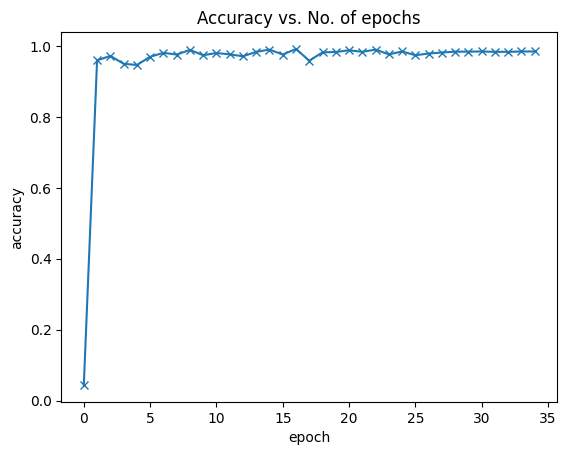

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

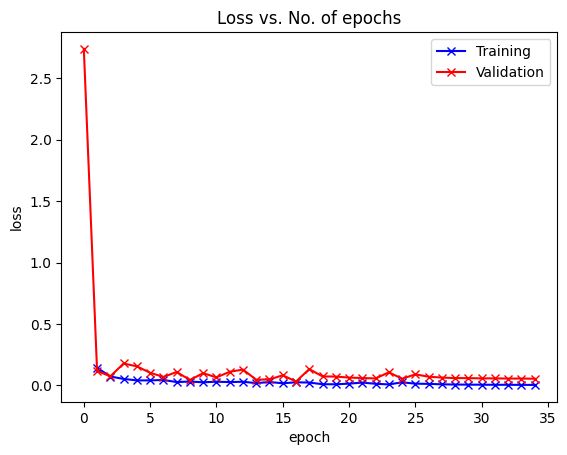

In [ ]:
plot_losses(history)

In [ ]:
history[-1]

{'val_loss': 0.05395208299160004,
 'val_acc': 0.9846153855323792,
 'val_precision': 0.990778579059829,
 'val_f1': 0.9845831076289221,
 'train_loss': 0.0034307143650949}

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: Tomato_Bacterial_spot
Prediction: Tomato_Bacterial_spot


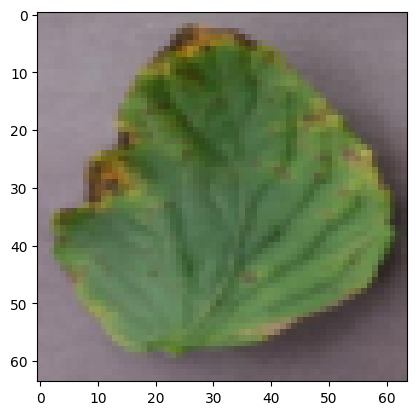

In [ ]:
show_image_prediction(*valid_ds[90])

Target: Tomato__Tomato_YellowLeaf__Curl_Virus
Prediction: Tomato__Tomato_YellowLeaf__Curl_Virus


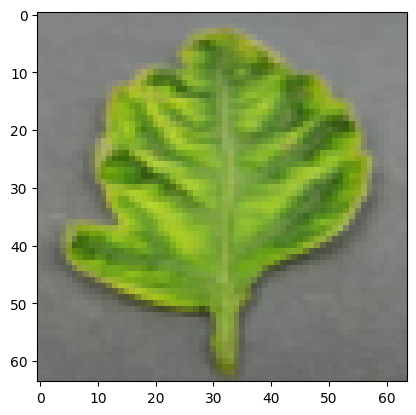

In [ ]:
show_image_prediction(*valid_ds[98])

Target: Tomato_Bacterial_spot
Prediction: Tomato_Bacterial_spot


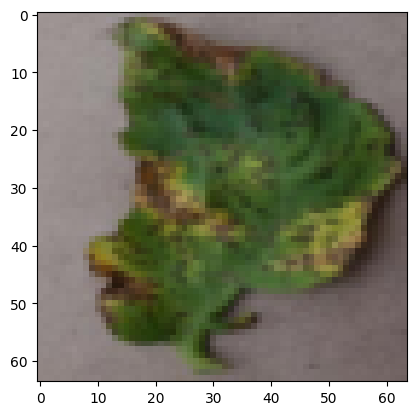

In [ ]:
show_image_prediction(*valid_ds[200])

<ipython-input-1-640ef20f6322>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


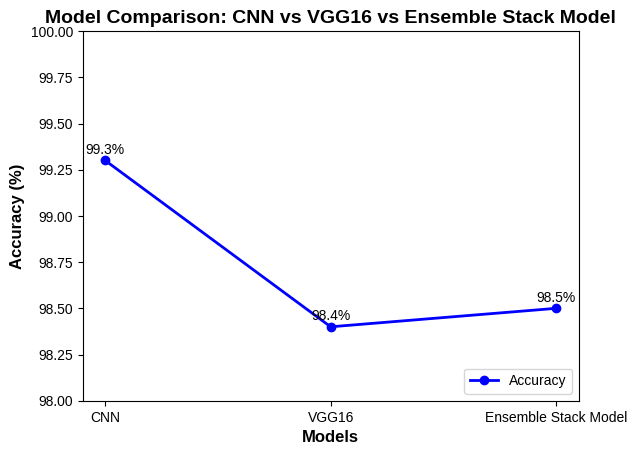

In [1]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
models = ['CNN', 'VGG16', 'Ensemble Stack Model']
accuracies = [99.3, 98.4, 98.5]

# Plotting the line graph with markers
plt.plot(models, accuracies, marker='o', linestyle='-', color='b', linewidth=2)

# Adding data labels
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt}%', (models[i], accuracies[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)

# Adjusting Y-axis range
plt.ylim(98, 100)

# Title and axis labels
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Comparison: CNN vs VGG16 vs Ensemble Stack Model', fontsize=14, fontweight='bold')

# Adding legend
plt.legend(['Accuracy'], loc='lower right', fontsize=10)

# Customize background and style
plt.style.use('seaborn-whitegrid')

# Display the graph
plt.show()